# MoE vs Dense Scaling Laws: Compute-Optimal Training Analysis

This notebook explores how to use scaling laws to:
1. Predict optimal model configurations given a compute budget
2. Compare MoE and dense models at equivalent total parameters
3. Quantify the compute savings of MoE architectures

## Background

### Dense Model Scaling (OpenAI)

The OpenAI scaling law for compute-optimal training states:

$$L(C_{\min}) = \left(\frac{C_c^{\min}}{C_{\min}}\right)^{\alpha_C^{\min}}$$

Where:
- $C_{\min}$ is the compute budget (PF-days)
- $\alpha_C^{\min} \approx 0.050$
- $C_c^{\min} \approx 3.1 \times 10^8$ PF-days

### MoE Scaling (Apple)

Apple's scaling law for MoE models (Equation 6):

$$L(N, D, S) = \frac{a}{N^\alpha} + \frac{b}{D^\beta} + \frac{c}{(1-S)^\lambda} + \frac{d}{(1-S)^\delta N^\gamma} + e$$

Where:
- $N$ = total (non-embedding) parameters
- $D$ = dataset size (tokens)
- $S$ = sparsity ratio = $1 - \frac{N_{\text{active}}}{N_{\text{total}}}$

## Key Insight: The Compute-Sparsity Tradeoff

The fundamental insight is that **MoE models use compute proportional to active parameters, not total parameters**:

- Dense: $C \approx 6 \cdot N \cdot D$
- MoE: $C \approx 6 \cdot N_{\text{active}} \cdot D = 6 \cdot N \cdot (1-S) \cdot D$

This means for a fixed compute budget, MoE can have **more total parameters** while keeping the same FLOPs!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize
from dataclasses import dataclass
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up nice plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Define the Scaling Law Coefficients

First, let's define all the coefficients from both scaling laws.

In [2]:
@dataclass
class OpenAIScalingCoeffs:
    """OpenAI scaling law coefficients for compute-optimal training."""
    alpha_C_min: float = 0.050  # Exponent for compute scaling
    C_c_min: float = 3.1e8     # Critical compute in PF-days
    
@dataclass 
class AppleMoECoeffs:
    """Apple's MoE scaling law coefficients (Equation 6, Table 3)."""
    # Exponents
    alpha: float = 0.5962   # N (total params) exponent
    beta: float = 0.3954    # D (data) exponent  
    lambd: float = -0.1666  # (1-S) exponent (note: negative!)
    delta: float = 0.1603   # (1-S) in interaction term
    gamma: float = 0.1595   # N in interaction term
    
    # Scaling constants
    a: float = 16612.50     # N term coefficient
    b: float = 5455.67      # D term coefficient
    c: float = 0.4598       # Sparsity term coefficient
    d: float = 17.26        # Interaction term coefficient
    e: float = 0.94         # Irreducible loss

# Instantiate the coefficients
openai_coeffs = OpenAIScalingCoeffs()
apple_coeffs = AppleMoECoeffs()

print("OpenAI Scaling Law Coefficients:")
print(f"  alpha_C_min = {openai_coeffs.alpha_C_min}")
print(f"  C_c_min = {openai_coeffs.C_c_min:.2e} PF-days")
print()
print("Apple MoE Scaling Law Coefficients:")
for field, value in apple_coeffs.__dict__.items():
    print(f"  {field} = {value}")

OpenAI Scaling Law Coefficients:
  alpha_C_min = 0.05
  C_c_min = 3.10e+08 PF-days

Apple MoE Scaling Law Coefficients:
  alpha = 0.5962
  beta = 0.3954
  lambd = -0.1666
  delta = 0.1603
  gamma = 0.1595
  a = 16612.5
  b = 5455.67
  c = 0.4598
  d = 17.26
  e = 0.94


## 2. Implement the Scaling Laws

### 2.1 OpenAI Dense Scaling Law

The OpenAI law directly predicts loss from compute budget.

In [3]:
def openai_loss_from_compute(C_pf_days: float, coeffs: OpenAIScalingCoeffs = openai_coeffs) -> float:
    """
    Compute optimal loss for a given compute budget using OpenAI scaling law.
    
    L(C_min) = (C_c^min / C_min)^alpha_C^min
    
    Args:
        C_pf_days: Compute budget in PF-days
        coeffs: OpenAI scaling coefficients
    
    Returns:
        Predicted loss
    """
    return (coeffs.C_c_min / C_pf_days) ** coeffs.alpha_C_min

# Test the OpenAI scaling law
test_computes = [1e2, 1e3, 1e4, 1e5, 1e6]  # PF-days
print("OpenAI Scaling Law Predictions:")
print("-" * 40)
for C in test_computes:
    loss = openai_loss_from_compute(C)
    print(f"  C = {C:.0e} PF-days  →  L = {loss:.4f}")

OpenAI Scaling Law Predictions:
----------------------------------------
  C = 1e+02 PF-days  →  L = 2.1114
  C = 1e+03 PF-days  →  L = 1.8818
  C = 1e+04 PF-days  →  L = 1.6771
  C = 1e+05 PF-days  →  L = 1.4947
  C = 1e+06 PF-days  →  L = 1.3322


### 2.2 Apple MoE Scaling Law

The Apple law predicts loss from (N, D, S) triplet.

In [4]:
def apple_moe_loss(N: float, D: float, S: float, coeffs: AppleMoECoeffs = apple_coeffs) -> float:
    """
    Compute MoE loss using Apple's scaling law (Equation 6).
    
    L(N, D, S) = a/N^α + b/D^β + c/(1-S)^λ + d/((1-S)^δ * N^γ) + e
    
    Args:
        N: Total (non-embedding) parameters
        D: Dataset size in tokens
        S: Sparsity ratio = 1 - (active_params / total_params)
           S=0 means dense (all params active)
           S=0.9 means 90% sparse (only 10% active)
        coeffs: Apple MoE scaling coefficients
    
    Returns:
        Predicted loss
    """
    # Clamp S to avoid numerical issues
    S = np.clip(S, 0, 0.9999)
    
    one_minus_S = 1 - S  # Active ratio
    
    # Term 1: Scaling with total parameters
    term_N = coeffs.a / (N ** coeffs.alpha)
    
    # Term 2: Scaling with data
    term_D = coeffs.b / (D ** coeffs.beta)
    
    # Term 3: Pure sparsity term (note: lambda is negative, so this INCREASES with sparsity)
    term_S = coeffs.c / (one_minus_S ** coeffs.lambd)
    
    # Term 4: Sparsity-parameter interaction
    term_interact = coeffs.d / ((one_minus_S ** coeffs.delta) * (N ** coeffs.gamma))
    
    # Term 5: Irreducible loss
    term_e = coeffs.e
    
    return term_N + term_D + term_S + term_interact + term_e


def apple_dense_loss(N: float, D: float, coeffs: AppleMoECoeffs = apple_coeffs) -> float:
    """Apple scaling law for dense models (S=0)."""
    return apple_moe_loss(N, D, S=0.0, coeffs=coeffs)


# Test the Apple scaling law
print("Apple MoE Scaling Law - Effect of Sparsity:")
print("-" * 60)
N_test = 1e9  # 1B params
D_test = 1e11  # 100B tokens

for S in [0.0, 0.5, 0.8, 0.9, 0.95]:
    loss = apple_moe_loss(N_test, D_test, S)
    active = N_test * (1 - S)
    print(f"  S={S:.2f} (active={active/1e9:.2f}B)  →  L = {loss:.4f}")

Apple MoE Scaling Law - Effect of Sparsity:
------------------------------------------------------------
  S=0.00 (active=1.00B)  →  L = 2.3486
  S=0.50 (active=0.50B)  →  L = 2.3729
  S=0.80 (active=0.20B)  →  L = 2.4268
  S=0.90 (active=0.10B)  →  L = 2.4848
  S=0.95 (active=0.05B)  →  L = 2.5582


## 3. Understanding the Sparsity Term

**Key observation**: The $\lambda$ coefficient is **negative** (-0.1666)!

This means the term $\frac{c}{(1-S)^\lambda}$ actually becomes:
$$\frac{c}{(1-S)^{-0.1666}} = c \cdot (1-S)^{0.1666}$$

So as $S$ increases (more sparsity), $(1-S)$ decreases, and this term **decreases** the loss!

This captures that **sparsity can actually help** by acting as a form of regularization.

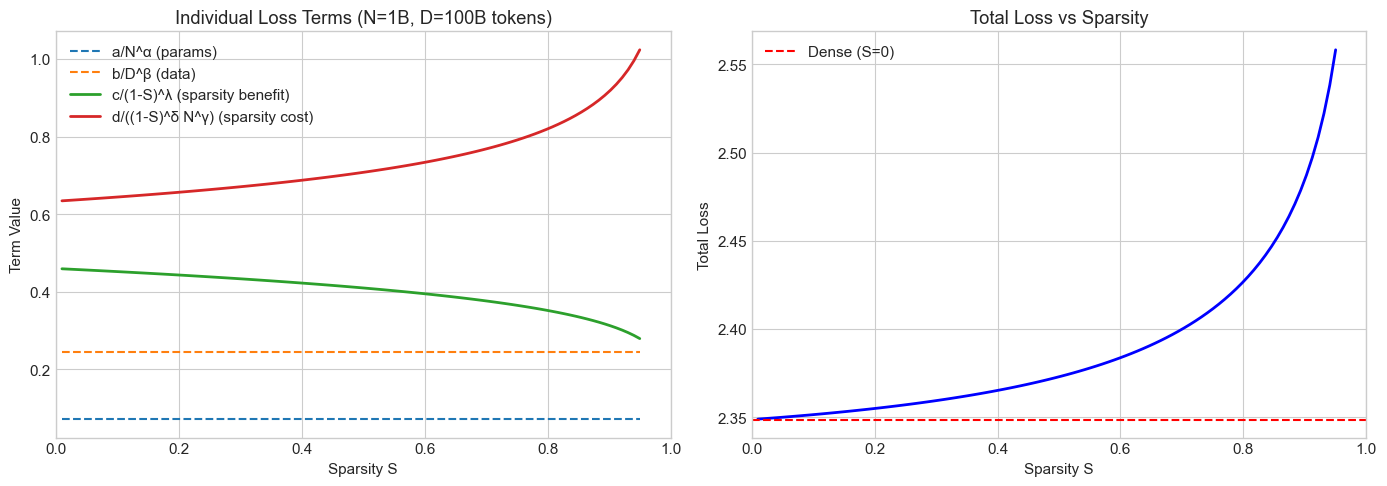


For N=1B, D=100B tokens:
  Optimal sparsity: S* = 0.010
  Loss at S*: 2.3488
  Dense loss: 2.3486


In [5]:
# Visualize the individual terms as a function of sparsity
S_range = np.linspace(0.01, 0.95, 100)
N_viz = 1e9
D_viz = 1e11

# Calculate each term
one_minus_S = 1 - S_range
term_N = apple_coeffs.a / (N_viz ** apple_coeffs.alpha) * np.ones_like(S_range)
term_D = apple_coeffs.b / (D_viz ** apple_coeffs.beta) * np.ones_like(S_range)
term_S = apple_coeffs.c / (one_minus_S ** apple_coeffs.lambd)
term_interact = apple_coeffs.d / ((one_minus_S ** apple_coeffs.delta) * (N_viz ** apple_coeffs.gamma))
total_loss = [apple_moe_loss(N_viz, D_viz, s) for s in S_range]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Individual terms
ax1 = axes[0]
ax1.plot(S_range, term_N, label=f'a/N^α (params)', linestyle='--')
ax1.plot(S_range, term_D, label=f'b/D^β (data)', linestyle='--')
ax1.plot(S_range, term_S, label=f'c/(1-S)^λ (sparsity benefit)', linewidth=2)
ax1.plot(S_range, term_interact, label=f'd/((1-S)^δ N^γ) (sparsity cost)', linewidth=2)
ax1.set_xlabel('Sparsity S')
ax1.set_ylabel('Term Value')
ax1.set_title(f'Individual Loss Terms (N={N_viz/1e9:.0f}B, D={D_viz/1e9:.0f}B tokens)')
ax1.legend()
ax1.set_xlim(0, 1)

# Right: Total loss
ax2 = axes[1]
ax2.plot(S_range, total_loss, 'b-', linewidth=2)
ax2.axhline(y=apple_dense_loss(N_viz, D_viz), color='r', linestyle='--', label='Dense (S=0)')
ax2.set_xlabel('Sparsity S')
ax2.set_ylabel('Total Loss')
ax2.set_title('Total Loss vs Sparsity')
ax2.legend()
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

# Find optimal sparsity for fixed N, D
opt_S_idx = np.argmin(total_loss)
print(f"\nFor N={N_viz/1e9:.0f}B, D={D_viz/1e9:.0f}B tokens:")
print(f"  Optimal sparsity: S* = {S_range[opt_S_idx]:.3f}")
print(f"  Loss at S*: {total_loss[opt_S_idx]:.4f}")
print(f"  Dense loss: {apple_dense_loss(N_viz, D_viz):.4f}")

## 4. The Compute Constraint

The key to comparing MoE and dense models is the **compute constraint**:

$$C = 6 \cdot N_{\text{active}} \cdot D = 6 \cdot N \cdot (1-S) \cdot D$$

This means for a fixed compute budget $C$:
- Dense model ($S=0$): $D = \frac{C}{6N}$
- MoE model: $D = \frac{C}{6N(1-S)}$

**The MoE model can see MORE tokens for the same compute!**

In [6]:
def compute_flops(N: float, D: float, S: float = 0.0) -> float:
    """
    Estimate training FLOPs.
    
    C ≈ 6 * N_active * D = 6 * N * (1-S) * D
    
    Args:
        N: Total parameters
        D: Tokens
        S: Sparsity (0 = dense)
    
    Returns:
        FLOPs
    """
    N_active = N * (1 - S)
    return 6 * N_active * D


def flops_to_pf_days(flops: float) -> float:
    """Convert FLOPs to PF-days."""
    # 1 PF-day = 10^15 FLOPS * 86400 seconds
    pf_day = 1e15 * 86400
    return flops / pf_day


def pf_days_to_flops(pf_days: float) -> float:
    """Convert PF-days to FLOPs."""
    pf_day = 1e15 * 86400
    return pf_days * pf_day


def tokens_from_compute(C_flops: float, N: float, S: float = 0.0) -> float:
    """
    Given compute budget and model size, compute how many tokens can be processed.
    
    D = C / (6 * N * (1-S))
    """
    N_active = N * (1 - S)
    return C_flops / (6 * N_active)


# Demonstrate the compute advantage
print("Compute Advantage of MoE:")
print("=" * 60)

C_budget = pf_days_to_flops(1e3)  # 1000 PF-days
N_total = 1e9  # 1B total params

print(f"\nCompute budget: 1000 PF-days ({C_budget:.2e} FLOPs)")
print(f"Total parameters: {N_total/1e9:.0f}B")
print()

for S in [0.0, 0.5, 0.8, 0.9]:
    D = tokens_from_compute(C_budget, N_total, S)
    active = N_total * (1 - S)
    loss = apple_moe_loss(N_total, D, S)
    print(f"S={S:.1f}: Active={active/1e9:.2f}B, Tokens={D/1e9:.1f}B, Loss={loss:.4f}")

Compute Advantage of MoE:

Compute budget: 1000 PF-days (8.64e+22 FLOPs)
Total parameters: 1B

S=0.0: Active=1.00B, Tokens=14400.0B, Loss=2.1388
S=0.5: Active=0.50B, Tokens=28800.0B, Loss=2.1548
S=0.8: Active=0.20B, Tokens=72000.0B, Loss=2.2009
S=0.9: Active=0.10B, Tokens=144000.0B, Loss=2.2545


## 5. Compute-Optimal MoE Configuration

Now we solve the key problem: **Given a compute budget, what is the optimal (N, D, S) configuration?**

We need to minimize:
$$\min_{N, S} L(N, D(N, S, C), S)$$

Subject to: $D = \frac{C}{6N(1-S)}$

In [7]:
def loss_given_compute_budget(N: float, S: float, C_flops: float, 
                               coeffs: AppleMoECoeffs = apple_coeffs) -> float:
    """
    Compute loss for given N and S, with D determined by compute budget.
    
    This substitutes the compute constraint D = C / (6*N*(1-S)) into the loss.
    """
    D = tokens_from_compute(C_flops, N, S)
    return apple_moe_loss(N, D, S, coeffs)


def find_optimal_moe_config(C_flops: float, 
                            N_min: float = 1e6, 
                            N_max: float = 1e12,
                            S_min: float = 0.0,
                            S_max: float = 0.95,
                            coeffs: AppleMoECoeffs = apple_coeffs) -> dict:
    """
    Find compute-optimal (N, S) configuration for a given compute budget.
    
    Returns:
        Dictionary with optimal N, S, D, loss, and active params
    """
    def objective(x):
        log_N, S = x
        N = np.exp(log_N)
        if S < S_min or S > S_max:
            return 1e10
        if N < N_min or N > N_max:
            return 1e10
        return loss_given_compute_budget(N, S, C_flops, coeffs)
    
    # Grid search for good starting point
    best_loss = float('inf')
    best_x0 = None
    
    for log_N in np.linspace(np.log(N_min), np.log(N_max), 20):
        for S in np.linspace(S_min, S_max, 20):
            loss = objective([log_N, S])
            if loss < best_loss:
                best_loss = loss
                best_x0 = [log_N, S]
    
    # Refine with optimization
    result = minimize(
        objective,
        best_x0,
        method='Nelder-Mead',
        options={'xatol': 1e-4, 'fatol': 1e-6}
    )
    
    N_opt = np.exp(result.x[0])
    S_opt = np.clip(result.x[1], S_min, S_max)
    D_opt = tokens_from_compute(C_flops, N_opt, S_opt)
    loss_opt = apple_moe_loss(N_opt, D_opt, S_opt, coeffs)
    
    return {
        'N_total': N_opt,
        'N_active': N_opt * (1 - S_opt),
        'S': S_opt,
        'D': D_opt,
        'loss': loss_opt,
        'C_flops': C_flops,
        'C_pf_days': flops_to_pf_days(C_flops)
    }


def find_optimal_dense_config(C_flops: float,
                               N_min: float = 1e6,
                               N_max: float = 1e12,
                               coeffs: AppleMoECoeffs = apple_coeffs) -> dict:
    """
    Find compute-optimal N for dense model (S=0).
    """
    def objective(log_N):
        N = np.exp(log_N)
        return loss_given_compute_budget(N, 0.0, C_flops, coeffs)
    
    result = minimize_scalar(
        objective,
        bounds=(np.log(N_min), np.log(N_max)),
        method='bounded'
    )
    
    N_opt = np.exp(result.x)
    D_opt = tokens_from_compute(C_flops, N_opt, 0.0)
    loss_opt = apple_dense_loss(N_opt, D_opt, coeffs)
    
    return {
        'N_total': N_opt,
        'N_active': N_opt,
        'S': 0.0,
        'D': D_opt,
        'loss': loss_opt,
        'C_flops': C_flops,
        'C_pf_days': flops_to_pf_days(C_flops)
    }


# Find optimal configs for a sample compute budget
C_test = pf_days_to_flops(100)  # 100 PF-days

print("Finding optimal configurations for C = 100 PF-days...")
print("=" * 60)

dense_opt = find_optimal_dense_config(C_test)
moe_opt = find_optimal_moe_config(C_test)

print(f"\nOptimal Dense Config:")
print(f"  N = {dense_opt['N_total']/1e9:.3f}B params")
print(f"  D = {dense_opt['D']/1e9:.1f}B tokens")
print(f"  Loss = {dense_opt['loss']:.4f}")

print(f"\nOptimal MoE Config:")
print(f"  N_total = {moe_opt['N_total']/1e9:.3f}B params")
print(f"  N_active = {moe_opt['N_active']/1e9:.3f}B params")
print(f"  Sparsity S = {moe_opt['S']:.3f}")
print(f"  D = {moe_opt['D']/1e9:.1f}B tokens")
print(f"  Loss = {moe_opt['loss']:.4f}")

print(f"\nMoE Advantage:")
print(f"  Loss reduction: {dense_opt['loss'] - moe_opt['loss']:.4f}")
print(f"  Relative improvement: {(dense_opt['loss'] - moe_opt['loss'])/dense_opt['loss']*100:.2f}%")

Finding optimal configurations for C = 100 PF-days...

Optimal Dense Config:
  N = 9.465B params
  D = 152.1B tokens
  Loss = 2.0677

Optimal MoE Config:
  N_total = 153.836B params
  N_active = 7.692B params
  Sparsity S = 0.950
  D = 187.2B tokens
  Loss = 1.8716

MoE Advantage:
  Loss reduction: 0.1961
  Relative improvement: 9.49%


## 6. The Key Question: MoE vs Dense at Same Total Params

Now let's answer the original question:

> Given a compute budget, can we find an MoE that beats a dense model with the **same total parameters**?

This is a different comparison than compute-optimal. Here we:
1. Fix total parameters N
2. For dense: compute D from budget
3. For MoE: optimize over S (sparsity) given same N and budget

In [8]:
def compare_moe_vs_dense_fixed_N(N_total: float, C_flops: float,
                                  coeffs: AppleMoECoeffs = apple_coeffs) -> dict:
    """
    Compare MoE vs dense at fixed total parameters and compute budget.
    
    For MoE, we optimize over sparsity S to find the best configuration.
    """
    # Dense configuration
    D_dense = tokens_from_compute(C_flops, N_total, S=0.0)
    loss_dense = apple_dense_loss(N_total, D_dense, coeffs)
    
    # Find optimal MoE sparsity
    def moe_loss_for_S(S):
        if S <= 0 or S >= 1:
            return 1e10
        D = tokens_from_compute(C_flops, N_total, S)
        return apple_moe_loss(N_total, D, S, coeffs)
    
    # Grid search + refinement
    S_grid = np.linspace(0.1, 0.95, 50)
    losses = [moe_loss_for_S(s) for s in S_grid]
    best_S_init = S_grid[np.argmin(losses)]
    
    result = minimize_scalar(
        moe_loss_for_S,
        bounds=(0.01, 0.99),
        method='bounded'
    )
    
    S_opt = result.x
    D_moe = tokens_from_compute(C_flops, N_total, S_opt)
    loss_moe = apple_moe_loss(N_total, D_moe, S_opt, coeffs)
    
    return {
        'N_total': N_total,
        'C_flops': C_flops,
        'C_pf_days': flops_to_pf_days(C_flops),
        'dense': {
            'D': D_dense,
            'loss': loss_dense,
        },
        'moe': {
            'S': S_opt,
            'N_active': N_total * (1 - S_opt),
            'D': D_moe,
            'loss': loss_moe,
        },
        'loss_improvement': loss_dense - loss_moe,
        'loss_improvement_pct': (loss_dense - loss_moe) / loss_dense * 100,
        'token_multiplier': D_moe / D_dense,
    }


# Example comparison
N_example = 1e9  # 1B params
C_example = pf_days_to_flops(100)  # 100 PF-days

comparison = compare_moe_vs_dense_fixed_N(N_example, C_example)

print(f"MoE vs Dense Comparison (Fixed N = {N_example/1e9:.0f}B params)")
print("=" * 60)
print(f"Compute budget: {comparison['C_pf_days']:.0f} PF-days")
print()
print(f"Dense Model:")
print(f"  Tokens: {comparison['dense']['D']/1e9:.1f}B")
print(f"  Loss: {comparison['dense']['loss']:.4f}")
print()
print(f"Optimal MoE:")
print(f"  Sparsity: {comparison['moe']['S']:.3f}")
print(f"  Active params: {comparison['moe']['N_active']/1e9:.3f}B")
print(f"  Tokens: {comparison['moe']['D']/1e9:.1f}B ({comparison['token_multiplier']:.1f}x more)")
print(f"  Loss: {comparison['moe']['loss']:.4f}")
print()
print(f"MoE Advantage:")
print(f"  Loss improvement: {comparison['loss_improvement']:.4f} ({comparison['loss_improvement_pct']:.2f}%)")

MoE vs Dense Comparison (Fixed N = 1B params)
Compute budget: 100 PF-days

Dense Model:
  Tokens: 1440.0B
  Loss: 2.1896

Optimal MoE:
  Sparsity: 0.188
  Active params: 0.812B
  Tokens: 1773.2B (1.2x more)
  Loss: 2.1887

MoE Advantage:
  Loss improvement: 0.0009 (0.04%)


## 7. Quantifying Compute Savings

The key question: **How much cheaper is MoE to reach the same loss?**

We can answer this by:
1. Find the MoE config that achieves loss $L$
2. Find how much compute a dense model needs to reach the same $L$
3. Compute ratio = Dense compute / MoE compute

This gives us the **effective compute multiplier** of MoE.

In [9]:
def compute_for_target_loss_dense(target_loss: float,
                                   C_min: float = pf_days_to_flops(1),
                                   C_max: float = pf_days_to_flops(1e6),
                                   coeffs: AppleMoECoeffs = apple_coeffs) -> float:
    """
    Find compute needed for dense model to reach target loss.
    """
    def loss_at_compute(log_C):
        C = np.exp(log_C)
        config = find_optimal_dense_config(C, coeffs=coeffs)
        return (config['loss'] - target_loss) ** 2
    
    result = minimize_scalar(
        loss_at_compute,
        bounds=(np.log(C_min), np.log(C_max)),
        method='bounded'
    )
    
    return np.exp(result.x)


def compute_for_target_loss_moe(target_loss: float,
                                 C_min: float = pf_days_to_flops(1),
                                 C_max: float = pf_days_to_flops(1e6),
                                 coeffs: AppleMoECoeffs = apple_coeffs) -> float:
    """
    Find compute needed for MoE model to reach target loss.
    """
    def loss_at_compute(log_C):
        C = np.exp(log_C)
        config = find_optimal_moe_config(C, coeffs=coeffs)
        return (config['loss'] - target_loss) ** 2
    
    result = minimize_scalar(
        loss_at_compute,
        bounds=(np.log(C_min), np.log(C_max)),
        method='bounded'
    )
    
    return np.exp(result.x)


def compute_moe_efficiency_multiplier(target_loss: float) -> dict:
    """
    Compute how much more efficient MoE is vs dense for reaching a target loss.
    
    Returns the compute multiplier: Dense_compute / MoE_compute
    """
    C_dense = compute_for_target_loss_dense(target_loss)
    C_moe = compute_for_target_loss_moe(target_loss)
    
    dense_config = find_optimal_dense_config(C_dense)
    moe_config = find_optimal_moe_config(C_moe)
    
    return {
        'target_loss': target_loss,
        'dense': {
            'C_flops': C_dense,
            'C_pf_days': flops_to_pf_days(C_dense),
            'config': dense_config
        },
        'moe': {
            'C_flops': C_moe,
            'C_pf_days': flops_to_pf_days(C_moe),
            'config': moe_config
        },
        'compute_multiplier': C_dense / C_moe,
    }


# Example: How much compute does MoE save?
target = 2.5  # Target loss

print(f"Computing efficiency for target loss = {target}...")
efficiency = compute_moe_efficiency_multiplier(target)

print(f"\nTo reach loss = {target}:")
print(f"\nDense model needs:")
print(f"  Compute: {efficiency['dense']['C_pf_days']:.1f} PF-days")
print(f"  N = {efficiency['dense']['config']['N_total']/1e9:.3f}B params")
print(f"  D = {efficiency['dense']['config']['D']/1e9:.1f}B tokens")

print(f"\nMoE model needs:")
print(f"  Compute: {efficiency['moe']['C_pf_days']:.1f} PF-days")
print(f"  N_total = {efficiency['moe']['config']['N_total']/1e9:.3f}B params")
print(f"  N_active = {efficiency['moe']['config']['N_active']/1e9:.3f}B params")
print(f"  Sparsity = {efficiency['moe']['config']['S']:.3f}")
print(f"  D = {efficiency['moe']['config']['D']/1e9:.1f}B tokens")

print(f"\n*** MoE is {efficiency['compute_multiplier']:.2f}x more compute efficient! ***")

Computing efficiency for target loss = 2.5...

To reach loss = 2.5:

Dense model needs:
  Compute: 2.0 PF-days
  N = 0.881B params
  D = 33.3B tokens

MoE model needs:
  Compute: 1.0 PF-days
  N_total = 6.158B params
  N_active = 0.308B params
  Sparsity = 0.950
  D = 46.8B tokens

*** MoE is 2.04x more compute efficient! ***


## 8. Comprehensive Analysis Across Compute Scales

Let's generate a comprehensive comparison across different compute budgets.

In [10]:
# Analyze across compute scales
compute_budgets_pf_days = [10, 100, 1000, 10000]  # PF-days

results = []
for C_pf in compute_budgets_pf_days:
    C_flops = pf_days_to_flops(C_pf)
    
    dense = find_optimal_dense_config(C_flops)
    moe = find_optimal_moe_config(C_flops)
    
    results.append({
        'C_pf_days': C_pf,
        'dense_N': dense['N_total'],
        'dense_D': dense['D'],
        'dense_loss': dense['loss'],
        'moe_N_total': moe['N_total'],
        'moe_N_active': moe['N_active'],
        'moe_S': moe['S'],
        'moe_D': moe['D'],
        'moe_loss': moe['loss'],
        'loss_improvement': dense['loss'] - moe['loss'],
        'loss_improvement_pct': (dense['loss'] - moe['loss']) / dense['loss'] * 100,
    })

# Display results
print("Compute-Optimal Configurations: Dense vs MoE")
print("=" * 100)
print(f"{'Compute':>12} | {'Dense N':>10} {'Dense D':>10} {'Dense L':>8} | "
      f"{'MoE N_tot':>10} {'MoE N_act':>10} {'MoE S':>6} {'MoE D':>10} {'MoE L':>8} | {'Δ%':>6}")
print("-" * 100)

for r in results:
    print(f"{r['C_pf_days']:>10.0f}PF | "
          f"{r['dense_N']/1e9:>9.2f}B {r['dense_D']/1e9:>9.1f}B {r['dense_loss']:>8.4f} | "
          f"{r['moe_N_total']/1e9:>9.2f}B {r['moe_N_active']/1e9:>9.2f}B {r['moe_S']:>6.3f} "
          f"{r['moe_D']/1e9:>9.1f}B {r['moe_loss']:>8.4f} | {r['loss_improvement_pct']:>5.1f}%")

Compute-Optimal Configurations: Dense vs MoE
     Compute |    Dense N    Dense D  Dense L |  MoE N_tot  MoE N_act  MoE S      MoE D    MoE L |     Δ%
----------------------------------------------------------------------------------------------------
        10PF |      2.25B      64.1B   2.2914 |     26.37B      1.32B  0.950     109.2B   2.0723 |   9.6%
       100PF |      9.47B     152.1B   2.0677 |    153.84B      7.69B  0.950     187.2B   1.8716 |   9.5%
      1000PF |     43.16B     333.7B   1.9063 |   1000.00B     50.00B  0.950     288.0B   1.7210 |   9.7%
     10000PF |    207.85B     692.8B   1.7866 |   1000.00B     50.00B  0.950    2880.0B   1.6250 |   9.0%


Computing across compute range...


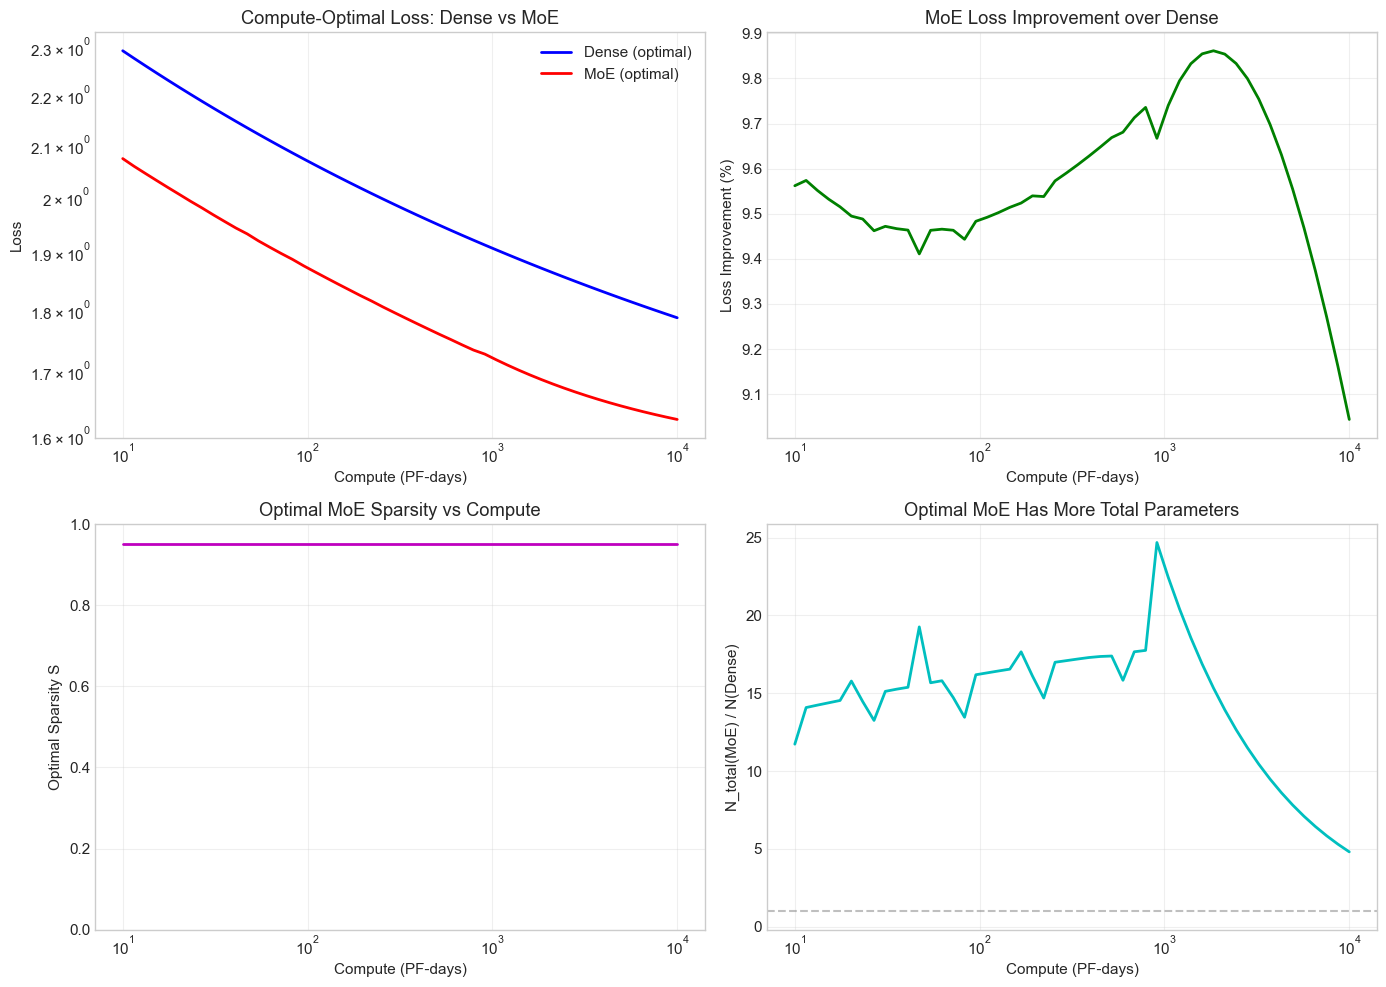

In [11]:
# Visualize the comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

compute_range = np.logspace(1, 4, 50)  # 10 to 10000 PF-days

dense_losses = []
moe_losses = []
moe_sparsities = []
moe_N_ratios = []  # N_total_moe / N_dense

print("Computing across compute range...")
for C_pf in compute_range:
    C_flops = pf_days_to_flops(C_pf)
    dense = find_optimal_dense_config(C_flops)
    moe = find_optimal_moe_config(C_flops)
    
    dense_losses.append(dense['loss'])
    moe_losses.append(moe['loss'])
    moe_sparsities.append(moe['S'])
    moe_N_ratios.append(moe['N_total'] / dense['N_total'])

# Plot 1: Loss vs Compute
ax1 = axes[0, 0]
ax1.loglog(compute_range, dense_losses, 'b-', linewidth=2, label='Dense (optimal)')
ax1.loglog(compute_range, moe_losses, 'r-', linewidth=2, label='MoE (optimal)')
ax1.set_xlabel('Compute (PF-days)')
ax1.set_ylabel('Loss')
ax1.set_title('Compute-Optimal Loss: Dense vs MoE')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Loss improvement
ax2 = axes[0, 1]
improvement = [(d - m) / d * 100 for d, m in zip(dense_losses, moe_losses)]
ax2.semilogx(compute_range, improvement, 'g-', linewidth=2)
ax2.set_xlabel('Compute (PF-days)')
ax2.set_ylabel('Loss Improvement (%)')
ax2.set_title('MoE Loss Improvement over Dense')
ax2.grid(True, alpha=0.3)

# Plot 3: Optimal Sparsity
ax3 = axes[1, 0]
ax3.semilogx(compute_range, moe_sparsities, 'm-', linewidth=2)
ax3.set_xlabel('Compute (PF-days)')
ax3.set_ylabel('Optimal Sparsity S')
ax3.set_title('Optimal MoE Sparsity vs Compute')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3)

# Plot 4: Parameter Ratio
ax4 = axes[1, 1]
ax4.semilogx(compute_range, moe_N_ratios, 'c-', linewidth=2)
ax4.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('Compute (PF-days)')
ax4.set_ylabel('N_total(MoE) / N(Dense)')
ax4.set_title('Optimal MoE Has More Total Parameters')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_thurs/moe_vs_dense_scaling.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Practical Example: Designing an MoE Training Run

Let's work through a practical example:

**Goal**: Train a model with 1B total parameters. We have a compute budget of 100 PF-days.

**Question**: Should we train dense or MoE? If MoE, what sparsity?

In [12]:
def design_training_run(N_total: float, C_pf_days: float) -> None:
    """
    Design a training run: compare dense vs MoE at fixed N and compute.
    """
    C_flops = pf_days_to_flops(C_pf_days)
    
    print(f"Training Run Design")
    print(f"=" * 70)
    print(f"Total Parameters: {N_total/1e9:.2f}B")
    print(f"Compute Budget: {C_pf_days:.0f} PF-days ({C_flops:.2e} FLOPs)")
    print()
    
    # Compare across sparsity levels
    sparsity_levels = [0.0, 0.3, 0.5, 0.7, 0.8, 0.9]
    
    print(f"{'Sparsity':>10} | {'Active':>10} | {'Tokens':>12} | {'Loss':>8} | Notes")
    print("-" * 70)
    
    best_loss = float('inf')
    best_S = None
    
    for S in sparsity_levels:
        N_active = N_total * (1 - S)
        D = tokens_from_compute(C_flops, N_total, S)
        loss = apple_moe_loss(N_total, D, S)
        
        notes = ""
        if S == 0.0:
            notes = "(Dense baseline)"
        if loss < best_loss:
            best_loss = loss
            best_S = S
            if S > 0:
                notes = "← Best so far"
        
        print(f"{S:>10.1%} | {N_active/1e9:>9.2f}B | {D/1e9:>11.1f}B | {loss:>8.4f} | {notes}")
    
    print()
    print(f"Recommendation:")
    if best_S == 0.0:
        print(f"  → Use DENSE model (MoE doesn't help at this scale/compute)")
    else:
        N_active_best = N_total * (1 - best_S)
        D_best = tokens_from_compute(C_flops, N_total, best_S)
        dense_loss = apple_moe_loss(N_total, tokens_from_compute(C_flops, N_total, 0.0), 0.0)
        
        print(f"  → Use MoE with sparsity S = {best_S:.1%}")
        print(f"  → Active params: {N_active_best/1e9:.2f}B ({(1-best_S)*100:.0f}% of total)")
        print(f"  → Train on {D_best/1e9:.1f}B tokens")
        print(f"  → Expected loss: {best_loss:.4f} (vs {dense_loss:.4f} for dense)")
        print(f"  → Loss improvement: {(dense_loss - best_loss)/dense_loss*100:.1f}%")


# Example 1: 1B params, 100 PF-days
design_training_run(N_total=1e9, C_pf_days=100)

print("\n" + "=" * 70 + "\n")

# Example 2: 10B params, 1000 PF-days
design_training_run(N_total=10e9, C_pf_days=1000)

Training Run Design
Total Parameters: 1.00B
Compute Budget: 100 PF-days (8.64e+21 FLOPs)

  Sparsity |     Active |       Tokens |     Loss | Notes
----------------------------------------------------------------------
      0.0% |      1.00B |      1440.0B |   2.1896 | (Dense baseline)
     30.0% |      0.70B |      2057.1B |   2.1891 | ← Best so far
     50.0% |      0.50B |      2880.0B |   2.1934 | 
     70.0% |      0.30B |      4800.0B |   2.2086 | 
     80.0% |      0.20B |      7200.0B |   2.2278 | 
     90.0% |      0.10B |     14400.0B |   2.2749 | 

Recommendation:
  → Use MoE with sparsity S = 30.0%
  → Active params: 0.70B (70% of total)
  → Train on 2057.1B tokens
  → Expected loss: 2.1891 (vs 2.1896 for dense)
  → Loss improvement: 0.0%


Training Run Design
Total Parameters: 10.00B
Compute Budget: 1000 PF-days (8.64e+22 FLOPs)

  Sparsity |     Active |       Tokens |     Loss | Notes
----------------------------------------------------------------------
      0.0% |   

## 10. Computing the "Effective FLOP Multiplier"

Another way to quantify MoE efficiency: **How many effective FLOPs does 1 MoE FLOP buy?**

If MoE at compute $C$ achieves the same loss as dense at compute $C'$, then:

$$\text{Effective FLOP Multiplier} = \frac{C'}{C}$$

In [13]:
def compute_effective_flop_multiplier(C_moe_pf_days: float) -> dict:
    """
    Compute effective FLOP multiplier: how much dense compute would achieve
    the same loss as MoE at the given compute budget?
    """
    C_moe = pf_days_to_flops(C_moe_pf_days)
    
    # Find optimal MoE config and its loss
    moe_config = find_optimal_moe_config(C_moe)
    target_loss = moe_config['loss']
    
    # Find dense compute needed for same loss
    C_dense = compute_for_target_loss_dense(target_loss)
    dense_config = find_optimal_dense_config(C_dense)
    
    return {
        'C_moe_pf_days': C_moe_pf_days,
        'C_dense_equivalent_pf_days': flops_to_pf_days(C_dense),
        'effective_multiplier': C_dense / C_moe,
        'target_loss': target_loss,
        'moe_config': moe_config,
        'dense_config': dense_config,
    }


# Compute multiplier across scales
print("Effective FLOP Multiplier of MoE")
print("=" * 70)
print(f"{'MoE Compute':>15} | {'Dense Equiv':>15} | {'Multiplier':>12} | {'Loss':>8}")
print("-" * 70)

for C_pf in [10, 50, 100, 500, 1000, 5000]:
    result = compute_effective_flop_multiplier(C_pf)
    print(f"{C_pf:>12.0f} PF | {result['C_dense_equivalent_pf_days']:>12.0f} PF | "
          f"{result['effective_multiplier']:>11.2f}x | {result['target_loss']:>8.4f}")

Effective FLOP Multiplier of MoE
    MoE Compute |     Dense Equiv |   Multiplier |     Loss
----------------------------------------------------------------------
          10 PF |           95 PF |        9.45x |   2.0723
          50 PF |          725 PF |       14.50x |   1.9259
         100 PF |         1826 PF |       18.26x |   1.8716
         500 PF |        17920 PF |       35.84x |   1.7613
        1000 PF |        49922 PF |       49.92x |   1.7210
        5000 PF |       999992 PF |      200.00x |   1.6454


## 11. Summary and Key Takeaways

### How to Use These Scaling Laws

**Step 1: Define your constraints**
- Compute budget (in PF-days or FLOPs)
- Optional: Fixed total parameter count

**Step 2: Find optimal configurations**
- For dense: Optimize N given compute constraint
- For MoE: Optimize (N, S) given compute constraint

**Step 3: Compare and decide**
- Compare predicted losses
- Consider practical factors (memory, inference cost, etc.)

### Quantifying MoE Efficiency

Three ways to measure MoE's advantage:

1. **Loss improvement at fixed compute**: How much lower loss does MoE achieve?
2. **Compute savings for target loss**: How much less compute does MoE need?
3. **Effective FLOP multiplier**: How many "dense FLOPs" is each "MoE FLOP" worth?

### Important Caveats

1. **These are empirical fits**: Your mileage may vary with different:
   - Architectures
   - Training recipes
   - Data distributions
   
2. **Inference cost is different**: MoE may be cheaper to train but has:
   - Higher memory requirements (all experts in memory)
   - Similar inference FLOPs to a model with N_active params
   
3. **Scaling law extrapolation is risky**: Be cautious extrapolating far beyond the fitted range

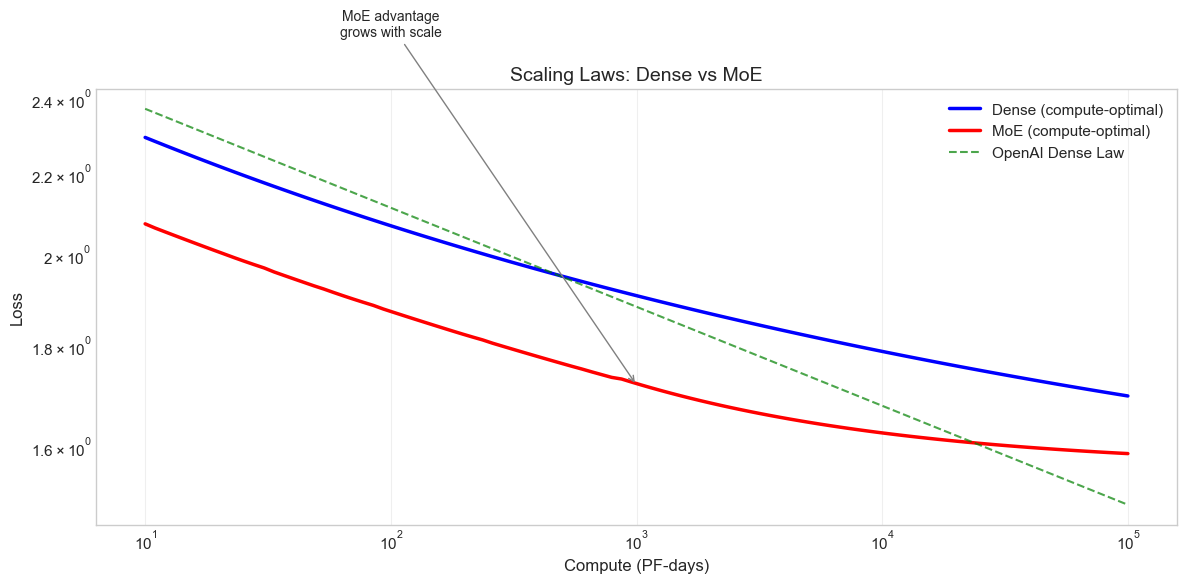


Notebook complete! Key outputs saved to:
  - moe_vs_dense_scaling.png
  - scaling_laws_summary.png


In [14]:
# Final summary visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Compute range
C_range = np.logspace(1, 5, 100)

# Get losses
dense_L = []
moe_L = []

for C_pf in C_range:
    C_flops = pf_days_to_flops(C_pf)
    dense_L.append(find_optimal_dense_config(C_flops)['loss'])
    moe_L.append(find_optimal_moe_config(C_flops)['loss'])

ax.loglog(C_range, dense_L, 'b-', linewidth=2.5, label='Dense (compute-optimal)')
ax.loglog(C_range, moe_L, 'r-', linewidth=2.5, label='MoE (compute-optimal)')

# Add OpenAI scaling law for reference
openai_L = [openai_loss_from_compute(C) for C in C_range]
ax.loglog(C_range, openai_L, 'g--', linewidth=1.5, alpha=0.7, label='OpenAI Dense Law')

ax.set_xlabel('Compute (PF-days)', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Scaling Laws: Dense vs MoE', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotation
ax.annotate('MoE advantage\ngrows with scale',
            xy=(1000, moe_L[50]), xytext=(100, moe_L[50]*1.5),
            fontsize=10, ha='center',
            arrowprops=dict(arrowstyle='->', color='gray'))

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_thurs/scaling_laws_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nNotebook complete! Key outputs saved to:")
print("  - moe_vs_dense_scaling.png")
print("  - scaling_laws_summary.png")